In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import *
from skimage.filters import *
from skimage.feature import *
from skimage.util import invert
from skimage.transform import rotate, resize, hough_line, hough_line_peaks
from skimage.morphology import disk
import os
from scipy import ndimage as nd
from scipy.signal import find_peaks
from scipy.special import softmax

In [2]:
images_path = os.path.join('dataset', 'images')
DS = pd.read_csv(os.path.join('dataset', 'dataset.csv'))

def get(filename):
    return np.array(Image.open(os.path.join(images_path, filename)))

def by_id(i):
    return get(f'{i}.jpg')

def random_images(k=1, names=False):
    fnames = np.random.choice(os.listdir(images_path), k)
    images = tuple(map(get, fnames))
    if names: return images, fnames
    else: return images

def fft2d(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

def ifft2d(image):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(image)))

def peaks_filter(x:np.array, y:np.array, peaks:np.array, k:int=1):
    ypeaks = y[peaks]
    max_peak = peaks[ypeaks == ypeaks.max()]
    for _ in range(k-1):
        max_peak = peaks[ypeaks == ypeaks[np.isin(ypeaks, y[x < x[max_peak][0]])].max()]
    return max_peak

def pixel_scale(image:np.array):
    fft = np.abs(fft2d(image))
    xfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[0], 1))
    yfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[1], 1))
    
    ymean = np.mean(fft, axis=1)
    xmean = np.mean(fft, axis=0)
    
    (ypeaks, _), (xpeaks, _) = find_peaks(ymean), find_peaks(xmean)
    Py = peaks_filter(yfreqs, ymean, ypeaks, 2)
    Px = peaks_filter(xfreqs, xmean, xpeaks, 2)
    
    return np.abs(xfreqs[Px][0]), np.abs(yfreqs[Py][0])

def pixel_scale_1d(sig1d:np.array):
    fft = np.abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sig1d))))
    freqs = np.fft.ifftshift(np.fft.fftfreq(len(fft), 1))
    
    peaks, _ = find_peaks(fft)
    P = peaks_filter(freqs, fft, peaks, 2)
    
    return np.abs(freqs[P][0])

In [230]:
def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(nd.convolve(image, np.real(kernel), mode='reflect')**2 +
                   nd.convolve(image, np.imag(kernel), mode='reflect')**2)

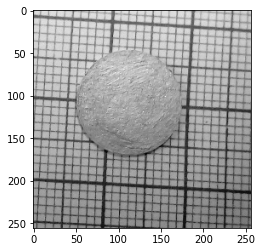

In [213]:
image = by_id(94)
#image = random_images()[0]
img = rgb2gray(image)
plt.imshow(img, cmap='gray')

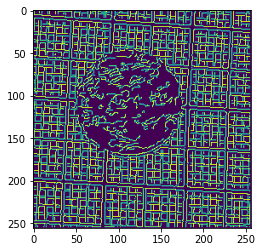

In [214]:
plt.imshow(canny(img))

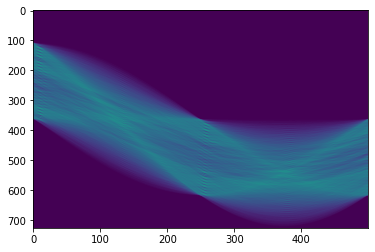

In [215]:
hspace, angles, dists = hough_line(canny(img), np.linspace(-np.pi/2, np.pi/2, 500))
plt.imshow(hspace, aspect='auto')

In [216]:
h_peaks, angles, dists = hough_line_peaks(hspace, angles, dists)

In [217]:
slopes = np.degrees(angles + np.pi/2)
slope_values = np.unique(slopes)
probs = np.array([np.sum(slopes == val) for val in slope_values])
probs

array([2, 8, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 4, 1, 1, 5, 2, 1])

In [218]:
img_slope = slope_values[probs == probs.max()][0]
img_slope

3.6072144288577173

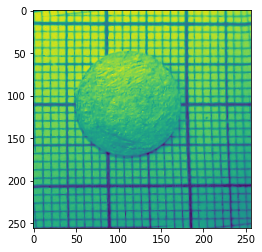

In [219]:
rot_img = rotate(img, img_slope, mode='reflect')
plt.imshow(rot_img)

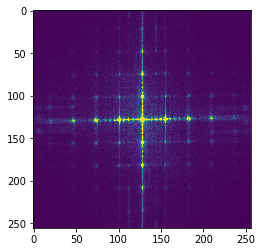

In [220]:
ifft = fft2d(rot_img)
fft = np.abs(ifft)
freqs = np.stack(np.meshgrid(
    np.fft.ifftshift(np.fft.fftfreq(img.shape[0])),
    np.fft.ifftshift(np.fft.fftfreq(img.shape[1]))
), axis=2)
plt.imshow(fft, vmax=fft.max()*0.005)

In [221]:
Fx, Fy = np.apply_along_axis(pixel_scale_1d, 0, rot_img), np.apply_along_axis(pixel_scale_1d, 1, rot_img)
(fx, d_fx), (fy, d_fy) = (np.median(Fx[Fx > 0.05]), np.std(Fx)), (np.median(Fy[Fy > 0.05]), np.std(Fy))
fx, fy

(0.10546875, 0.10546875)

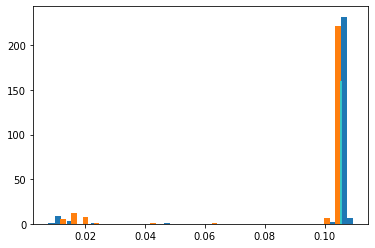

In [222]:
plt.hist(Fx, bins=50)
plt.hist(Fy, bins=50)
plt.vlines(fx, 0, 160, color='red')
plt.vlines(fy, 0, 160, color='cyan')
plt.show()

In [223]:
pixel_scale(rot_img)

(0.10546875, 0.10546875)

In [224]:
kernel_x = gabor_kernel(fx, theta=0)
kernel_y = gabor_kernel(fy, theta=np.pi/2)

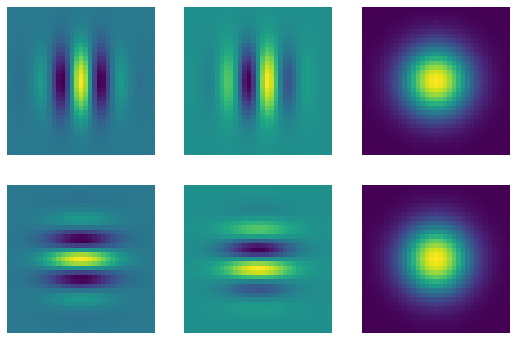

In [225]:
fig, axs = plt.subplots(2, 3, figsize=(9, 6))

for i, kaxis in enumerate([kernel_x, kernel_y]):
    for j, part in enumerate([np.real, np.imag, np.abs]):
        axs[i][j].imshow(part(kaxis))
        axs[i][j].axis('off')
        
plt.show()

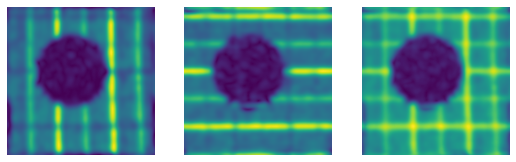

In [226]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

gabor_x = power(rot_img, kernel_x)
gabor_y = power(rot_img, kernel_y)
filtered = gabor_x + gabor_y

ax1.imshow(gabor_x)
ax2.imshow(gabor_y)
ax3.imshow(filtered)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

plt.show()

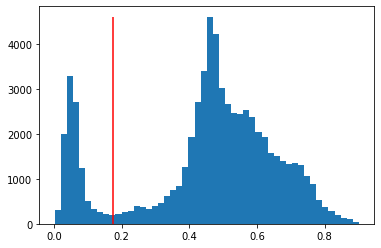

In [227]:
hist, bins, _ = plt.hist(filtered.flat, bins=50)
plt.vlines(threshold_minimum(filtered), 0, hist.max(), color='red')
plt.show()

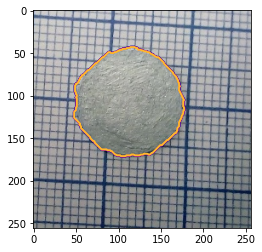

In [228]:
plt.imshow(image)
mask = filtered < threshold_minimum(filtered)
mask = nd.binary_opening(mask, iterations=10)
mask = nd.binary_closing(mask, iterations=10)
mask = nd.binary_dilation(mask, iterations=5)
plt.contour(rotate(mask, -img_slope), cmap='plasma')

115.jpg, 14.jpg, 229.jpg, 161.jpg, 58.jpg, 134.jpg, 260.jpg, 3.jpg, 34.jpg, 20.jpg, 350.jpg, 318.jpg, 343.jpg, 141.jpg, 191.jpg, 236.jpg, 304.jpg, 207.jpg, 11.jpg, 180.jpg, 54.jpg, 14.jpg, 77.jpg, 315.jpg, 224.jpg, 

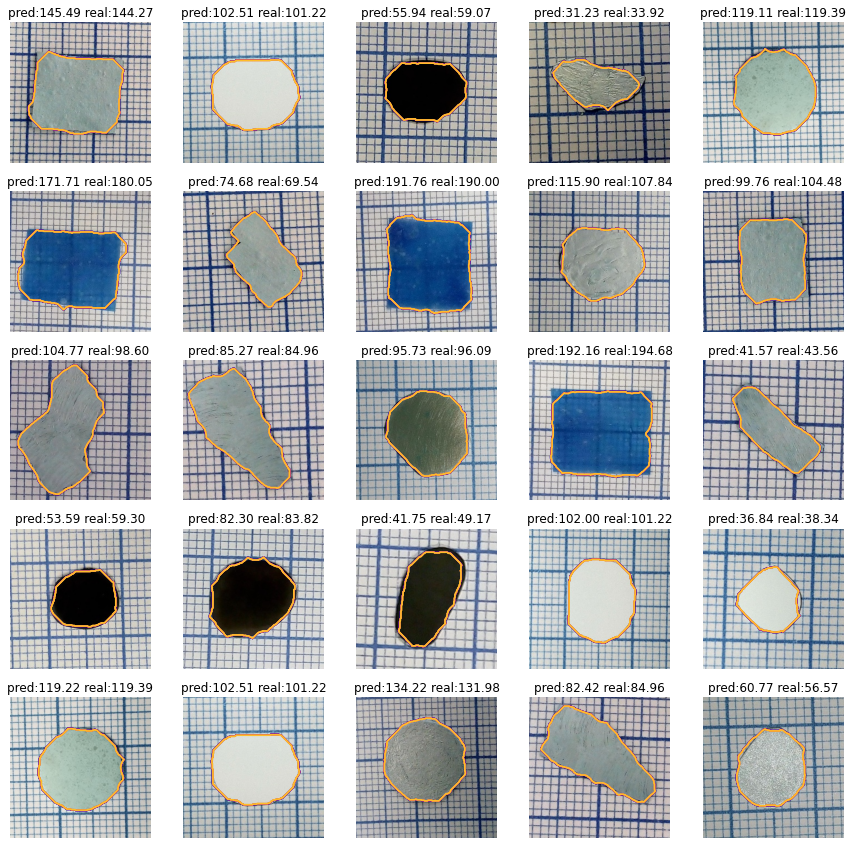

In [233]:
n = 5
r = 5
fig, axs = plt.subplots(r, n, figsize=(15, 3*r))
axs = axs.flatten()

for i, (image, name) in enumerate(zip(*random_images(r*n, names=True))):
    print(name, end=', ')
    
    img = rgb2gray(image)
    
    _, angles, _ = hough_line_peaks(*hough_line(canny(img), np.linspace(-np.pi/2, np.pi/2, 500)))
    slopes = np.degrees(angles + np.pi/2)
    slope_values = np.unique(slopes)
    probs = np.array([np.sum(slopes == val)/len(slopes) for val in slope_values])
    img_slope = slope_values[probs == probs.max()][0]
    img = rotate(img, img_slope, mode='reflect')
    
    Fx = np.apply_along_axis(pixel_scale_1d, 0, image)
    Fy = np.apply_along_axis(pixel_scale_1d, 1, image)
    fx, fy = np.median(Fx[Fx > 0.025]), np.median(Fy[Fy > 0.025])
    filtered = power(img, gabor_kernel(fx, theta=0)) + power(img, gabor_kernel(fy, theta=np.pi/2))
    mask = filtered < threshold_minimum(filtered)
    mask = nd.binary_opening(mask, iterations=14)
    mask = nd.binary_closing(mask, iterations=10)
    mask = nd.binary_dilation(mask, iterations=5)
    mask = rotate(mask, -img_slope)
    
    axs[i].imshow(image)
    axs[i].contour(mask, cmap='plasma')
    
    axs[i].set_title(f'pred:{np.sum(mask)*fx*fy:.2f} real:{float(DS.loc[DS.filename == name].area):.2f}')
    axs[i].axis('off')
    
plt.show()